# Manufacturing Causal-Net 

The target of the notebook is to learn *causal relations* in a dataset generated from a manufacturing simulator and, secondly, apply some *do-calculus operation* to observe effects of potential intervetions.

The simulator has been built using *Simpy*. Furhter information about Simpy in the following link: https://simpy.readthedocs.io/en/latest/index.html

The tools used are: 
- Pandas for data import and manipulation
- CausalNex for causal learning

In particular, "*CausalNex is a Python library that uses Bayesian Networks to combine machine learning and domain expertise for causal reasoning*". 

The relative documentation is available here: https://causalnex.readthedocs.io/en/latest/index.html

## Preparing the workspace
All the necessary tools has been downloaded and installed via the venv associated to the project. 
Refer to the requirements.txt file for further information.


### Importing necessary libraries
All the other necessary lirbaries are imported. They are: 
- os, time, datetime: for file handling operations 
- pandas: for data import, cleaning and input for CausalNex 
- causalnex.structure.notears: for network generation from pandas data
- networkx: for resulting network plotting

In [1]:
# Importing libraries
import shutil
import os
import time
import datetime
import networkx
import pandas
from causalnex.structure.notears import from_pandas

## Preparing the data set
The dataset generated from the simulation is exported as within a folder. 

The folder name is "yyyy.mm.dd-hh.mm-log", reporting the moment in time where the simulation started. The folder is placed inside of the Google Colab project folder.

The file containing the data is called "merged_logs.csv". It is imported as a Pandas Dataframe with the method "read_csv".

After the import, the head of the dataset and other dataset features are displayed.

---

The dataset used for the published experiment is "2022.03.14-11.54-log".

In [2]:
# Cleaning from previous runs
deleting_folder = os.listdir(os.path.join('dataset/'))
for i in range(len(deleting_folder)):
    if deleting_folder[i].startswith('.'):
        continue
    else:
        result = shutil.rmtree(os.path.join('dataset/' + deleting_folder[i]))

print('Dataset folder cleaned.')

# Moving the last run logs
working_folder = os.listdir(os.path.join('../manufacturing_model/logs'))
print(working_folder)
for i in range(len(working_folder)):
    print('working-folder' + working_folder[i])
    if working_folder[i].startswith('.'):
        continue
    else:
        to_move = working_folder[i]
        print('to move' + to_move)
        destination = shutil.copytree(os.path.join('../manufacturing_model/logs/' + to_move), os.path.join('dataset/' + to_move))
        print('Files copied in ' + destination)

Dataset folder cleaned.
['.gitkeep', '2022.09.16-12.14']
working-folder.gitkeep
working-folder2022.09.16-12.14
to move2022.09.16-12.14
Files copied in dataset/2022.09.16-12.14


In [3]:
# Retrieving the last run log file
# Setting the csv path 
CSV_PATH = os.path.join(destination + '/merged_logs')

#CSV_PATH = 'dataset'

CSV_FILE_NAME = os.path.join('/merged_logs.csv')
CSV_FILE_PATH = CSV_PATH + CSV_FILE_NAME

LIGHT_CSV_FILE_NAME = os.path.join('/light-logs.csv')
LIGHT_CSV_FILE_PATH = CSV_PATH + LIGHT_CSV_FILE_NAME


In [4]:
# Preparing the data set
# Unzipping the folder
#shutil.unpack_archive(zip_dataset_file, format='zip')

# Getting the dataframe from the file
data = pandas.read_csv(CSV_FILE_PATH, delimiter=',')

# Displaying the head and other dataset characteristics
print(data.head(10))
print('\n')
print(data.dtypes)
print('\n')
print(data.columns)


   step  input Machine B  time process Machine B  output Machine B  \
0   0.0              200                       0                 0   
1   0.1              200                       0                 0   
2   1.0              200                       0                 0   
3   1.1              200                       0                 0   
4   1.5              199                       0                 0   
5   1.6              199                     237                 0   
6   2.0              199                     237                 0   
7   2.1              199                     237                 0   
8   3.0              199                     237                 0   
9   3.1              199                     237                 0   

   produced Machine B  failure Machine B  MTTF Machine B  \
0                   0                  0           86400   
1                   0                  0           86400   
2                   0                  0         

## Data cleaning and preparation
Since the dataset is virtually generated, NaN or missing value are not present.

Btw, some data preparation is computed. 

### Splitting the step column
The step column has the form of "step.moment": this is not really the meaning of the step used by Simpy. Is instead a "trick" to make logs and debugging easier in the previous phase.

So, for this phase, is more coherent to split this column into two different columns, namely "step" and "moment".

---

The split is performed in 3 steps: 
1. The "step" column is converted in type, from float to string. The result is saved in a new columns called "step_str" attached on the right to the initial dataframe. 
2. Using the str.split method, the "step_str" column is split into 2 columns at the "." (*point*). The resulting columns are saved into 2 columns called "step" and "moment". 
3. The no more necessary temporary column "step_str" is dropped.

Finally, the columns are reordered keeping the new "step" and "moment" columns on the left of the dataset and converting them into int type. 

In [5]:
# Splitting the "step" column into "step" and "moment" in 3 steps:
# 1. Converting the step col into string type
data["step_str"] = data["step"].astype(str)
# 2. Using str.split to split the col at the "."
data[["step", "moment"]] = data.step_str.str.split(".", expand = True)
# 3. Dropping the temp col
data.drop(columns=["step_str"], inplace=True)

# Reordering the result
data = data[["step", "moment", "failure Machine A", "Machine A flag", 
      "failure Machine B",  "Machine B flag", "failure Machine C", 
      "Machine C flag"]]

# Converting everything in int 
data = data.astype(int)

print(data)


            step  moment  failure Machine A  Machine A flag  \
0              0       0                  0               0   
1              0       1                  0               0   
2              1       0                  0               0   
3              1       1                  0               0   
4              1       5                  0               0   
...          ...     ...                ...             ...   
1250819  1036795       0                  0               0   
1250820  1036796       0                  0               0   
1250821  1036797       0                  0               0   
1250822  1036798       0                  0               0   
1250823  1036799       0                  0               0   

         failure Machine B  Machine B flag  failure Machine C  Machine C flag  
0                        0               0                  0               0  
1                        0               0                  0               0  
2  

## Dropping unnecessary columns for learning 
In the previous step, during the columns reordering, not all the columns of the initial dataset have been used. For that reason, the unused columns have been dropped. 

So, there are only 2 columns left to be dropped: "step" and "moment". 

They are not necessary since the Bayesian Network used are not time-dependent: they just analyse the datast line-to-line trying to understand relations between features, without taking into account the time. 

In the following, "step" and "moment" are dropped.

In [6]:
# Dropping the unneccessary columns
data.drop(columns=["step", "moment"], inplace=True)
print(data)


         failure Machine A  Machine A flag  failure Machine B  Machine B flag  \
0                        0               0                  0               0   
1                        0               0                  0               0   
2                        0               0                  0               0   
3                        0               0                  0               0   
4                        0               0                  0               0   
...                    ...             ...                ...             ...   
1250819                  0               0                  0               0   
1250820                  0               0                  0               0   
1250821                  0               0                  0               0   
1250822                  0               0                  0               0   
1250823                  0               0                  0               0   

         failure Machine C 

## Saving the cleaned dataset in a dedicated CSV file
The processed dataset is now ready in order to be processed by CausalNex. 

Before launching the learning phase, the dataset is exported as a CSV file in the same file location of the initial dataset CSV. 

The file is called "light-logs.csv", because "lighter" with respect to the initial dataset. 

In [7]:
# Saving the light dataset into csv
data.to_csv(LIGHT_CSV_FILE_PATH)


## Data analysis 
Before the learning phase, data is analysed in order to understand the impact of the dataset structure on the causal-learning. 

The structure of the dataset, in fact, will let us understand in advance if some relationships will be caught or not. 

To do so, the following metrics will be computed: 
- fault_Machine x = 1 AND flag_Machine_x = 1 AND flag_Machine_C = 1
- fault_Machine x = 1 AND flag_Machine_x = 1 AND flag_Machine_C = 0

The ratio between those 2 metrics will let the user understand if the breakdown of an upstream machine (Machine A and B in the sim) has affected the downstream machine (Machine C in the sim). 

If the impact is high, the relation is likely to be caught. 


In [8]:
# Loading the light dataset into csv
data = pandas.read_csv(LIGHT_CSV_FILE_PATH, delimiter=',', index_col=0)
data


,failure Machine A,Machine A flag,failure Machine B,Machine B flag,failure Machine C,Machine C flag
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
1250819,0,0,0,0,0,0
1250820,0,0,0,0,0,0
1250821,0,0,0,0,0,0
1250822,0,0,0,0,0,0


In [9]:
# Machine A Ratio
fault_A_flag = data[(data['failure Machine A'] == 1) & 
                    (data['Machine A flag'] == 1)].count()

fault_A_flag_C_High = data[(data['failure Machine A'] == 1) & 
                           (data['Machine A flag'] == 1) & 
                           (data['Machine C flag'] == 1)].count()

fault_A_flag_C_Low = data[(data['failure Machine A'] == 1) & 
                          (data['Machine A flag'] == 1) & 
                          (data['Machine C flag'] == 0)].count()

ratio_A_high = fault_A_flag_C_High[0]/fault_A_flag[0]
ratio_A_low = fault_A_flag_C_Low[0]/fault_A_flag[0]

print('Ratio A High: ', ratio_A_high)
print('Ratio A Low: ', ratio_A_low)


Ratio A High:  0.7561257500514548
Ratio A Low:  0.24387424994854529


In [10]:
# Machine B Ratio
fault_B_flag = data[(data['failure Machine B'] == 1) & 
                    (data['Machine B flag'] == 1)].count()

fault_B_flag_C_High = data[(data['failure Machine B'] == 1) & 
                           (data['Machine B flag'] == 1) & 
                           (data['Machine C flag'] == 1)].count()

fault_B_flag_C_Low = data[(data['failure Machine B'] == 1) & 
                          (data['Machine B flag'] == 1) & 
                          (data['Machine C flag'] == 0)].count()

ratio_B_high = fault_B_flag_C_High[0]/fault_B_flag[0]
ratio_B_low = fault_B_flag_C_Low[0]/fault_B_flag[0]

print('Ratio B High: ', ratio_B_high)
print('Ratio B Low: ', ratio_B_low)


Ratio B High:  0.7205327031776944
Ratio B Low:  0.2794672968223056


## CausalNex application: applying the causal-network


In [11]:
# Eliminating spaces from column names - useful for later
column_dict = {}
for el in data.columns:
  key = el
  el = el.replace(' ', '_')
  column_dict [key] = el

data = data.rename(columns=column_dict)

# Getting tabu child nodes
tabu_child_list = [x for x in data.columns if 'failure' in x]

print('Tabu child list: ', tabu_child_list)

# Training the model
# Declaring and mining the structure of the causal-net
start_time = time.time()
structure_model = from_pandas(data, tabu_child_nodes=tabu_child_list)
finish_time = time.time()
sim_time = finish_time - start_time

# Printing the structure model with Python
print("Total training time: {} min, {} secs".format(round(sim_time/60, 0), 
                                                    round(sim_time%60, 0)))
print(structure_model)


Tabu child list:  ['failure_Machine_A', 'failure_Machine_B', 'failure_Machine_C']
Total training time: 1.0 min, 39.0 secs
StructureModel with 6 nodes and 15 edges


In [12]:
data.shape

(1250824, 6)

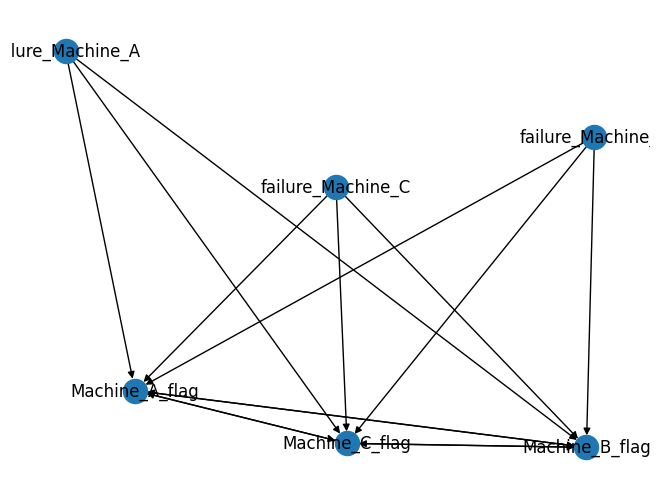

In [13]:
# Printing the structure model with networkx
networkx.draw(structure_model, with_labels=True)


StructureModel with 6 nodes and 6 edges


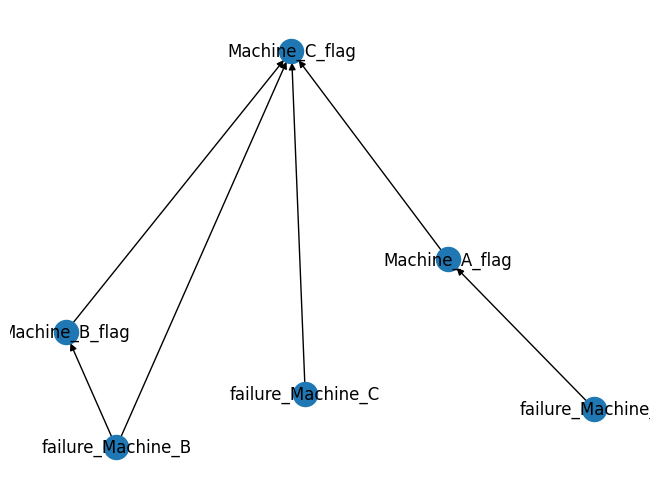

In [14]:
structure_model.remove_edges_below_threshold(0.1)
print(structure_model)
# Printing the structure model again
networkx.draw(structure_model, with_labels=True)


StructureModel with 6 nodes and 5 edges


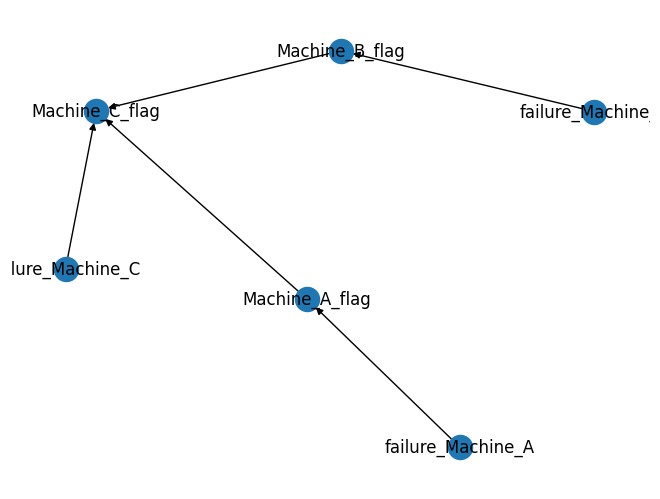

In [15]:
structure_model.remove_edges_below_threshold(0.2)
print(structure_model)
# Printing the structure model again
networkx.draw(structure_model, with_labels=True)


StructureModel with 6 nodes and 5 edges


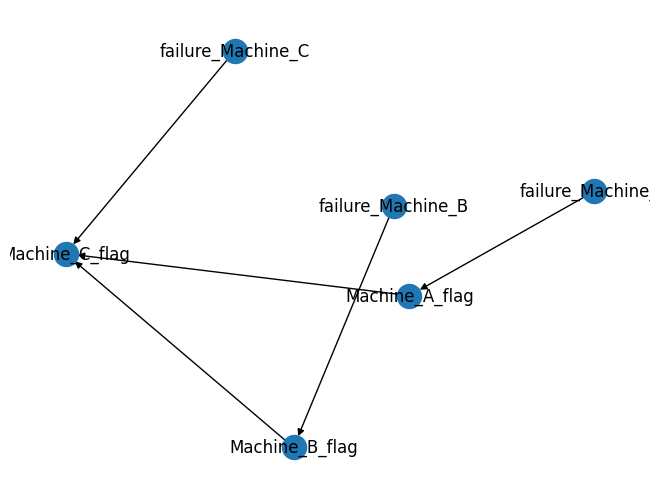

In [16]:
structure_model.remove_edges_below_threshold(0.3)
print(structure_model)
# Printing the structure model again
networkx.draw(structure_model, with_labels=True)


In [17]:
# Exporting the model at the best threshold (as said in the NOTEARS arxiv paper)
networkx.drawing.nx_pydot.write_dot(structure_model, CSV_PATH + '/graph.dot')

In [18]:
# Getting weights of the generated model in Python dict structure
edges_weights_dict = networkx.to_dict_of_dicts(structure_model)

# Saving the weights of the generated model
with open(os.path.join(CSV_PATH + '/edges-weights.txt'), 'a') as f:
  for k1 in edges_weights_dict:
    for k2 in edges_weights_dict[k1]:
      text = k1 + ' -> ' + k2 + ': ' \
            + str(edges_weights_dict[k1][k2].get('weight'))
    f.write(text)
  f.close()


In [19]:
# Bayesian network instantiation
from causalnex.network import BayesianNetwork

bayesian_net = BayesianNetwork(structure_model)


/home/mex/Scrivania/Workspace/Projects/Phd-Projects/Phd-Manufacturing-Distributed/venv/lib/python3.8/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


In [20]:
from sklearn.model_selection import train_test_split

# Split 90% train and 10% test
training_data = data.copy()
train, test = train_test_split(training_data, train_size=0.9, test_size=0.1, 
                               random_state=7)

# Fitting node states into the Bayesian Network: here they are inferred from the 
# input data, but sometimes is necessary to provide a dictionary for them to be 
# assigned
bayesian_net = bayesian_net.fit_node_states(training_data)

# Fitting the data into the prepared net
bayesian_net = bayesian_net.fit_cpds(train, method="BayesianEstimator", 
                                     bayes_prior="K2")

bayesian_net.cpds


{'failure_Machine_A':                            
 failure_Machine_A          
 0                  0.843992
 1                  0.156008,
 'Machine_A_flag': failure_Machine_A         0        1
 Machine_A_flag                      
 0                  0.997391  0.02823
 1                  0.002609  0.97177,
 'Machine_C_flag': Machine_A_flag           0                                  1            \
 Machine_B_flag           0                   1              0             
 failure_Machine_C        0         1         0    1         0         1   
 Machine_C_flag                                                            
 0                  0.99628  0.170774  0.406209  0.5  0.337589  0.201853   
 1                  0.00372  0.829226  0.593791  0.5  0.662411  0.798147   
 
 Machine_A_flag                    
 Machine_B_flag            1       
 failure_Machine_C         0    1  
 Machine_C_flag                    
 0                  0.000021  0.5  
 1                  0.999979  0.5  

In [21]:
from causalnex.evaluation import classification_report, roc_auc

# ROC, AUC curve computation for failure Machine A
machine_A_failure_roc, machine_A_failure_auc = roc_auc(bayesian_net, test, "failure_Machine_A")
print('Machine A failure Node AUC: ', machine_A_failure_auc)

# ROC, AUC curve computation for Machine A flag
machine_A_flag_roc, machine_A_flag_auc = roc_auc(bayesian_net, test, "Machine_A_flag")
print('Machine A flag Node AUC: ', machine_A_flag_auc)

# ROC, AUC curve computation for failure Machine B
machine_B_failure_roc, machine_B_failure_auc = roc_auc(bayesian_net, test, "failure_Machine_B")
print('Machine B failure Node AUC: ', machine_B_failure_auc)

# ROC, AUC curve computation for Machine B flag
machine_B_flag_roc, machine_B_flag_auc = roc_auc(bayesian_net, test, "Machine_B_flag")
print('Machine B flag Node AUC: ', machine_B_flag_auc)

# ROC, AUC curve computation for failure Machine C
machine_C_failure_roc, machine_C_failure_auc = roc_auc(bayesian_net, test, "failure_Machine_C")
print('Machine C failure node Node AUC: ', machine_C_failure_auc)

# ROC, AUC curve computation for Machine C flag
machine_C_flag_roc, machine_C_flag_auc = roc_auc(bayesian_net, test, "Machine_C_flag")
print('Machine C flag Node AUC: ', machine_C_flag_auc)


Machine A failure Node AUC:  0.8451108463979917
Machine A flag Node AUC:  0.9972088667675321
Machine B failure Node AUC:  0.8609563250001999
Machine B flag Node AUC:  0.9973645779304554
Machine C failure node Node AUC:  0.9852338047536435
Machine C flag Node AUC:  0.9811262974303523


In [22]:
# Model quality evaluation for failure Machine A
classification_report(bayesian_net, test, "failure_Machine_A")


/home/mex/Scrivania/Workspace/Projects/Phd-Projects/Phd-Manufacturing-Distributed/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mex/Scrivania/Workspace/Projects/Phd-Projects/Phd-Manufacturing-Distributed/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mex/Scrivania/Workspace/Projects/Phd-Projects/Phd-Manufacturing-Distributed/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

{'failure_Machine_A_0': {'precision': 0.8451108463979917,
  'recall': 1.0,
  'f1-score': 0.9160542826441125,
  'support': 105709},
 'failure_Machine_A_1': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 19374},
 'accuracy': 0.8451108463979917,
 'macro avg': {'precision': 0.42255542319899586,
  'recall': 0.5,
  'f1-score': 0.45802714132205624,
  'support': 125083},
 'weighted avg': {'precision': 0.71421234269953,
  'recall': 0.8451108463979917,
  'f1-score': 0.7741674101518711,
  'support': 125083}}

In [23]:
# Model quality evaluation for Machine A flag
classification_report(bayesian_net, test, "Machine_A_flag")


{'Machine_A_flag_0': {'precision': 0.9978431354000132,
  'recall': 0.994775310039138,
  'f1-score': 0.9963068611153091,
  'support': 106035},
 'Machine_A_flag_1': {'precision': 0.9714049757406834,
  'recall': 0.9880302393952121,
  'f1-score': 0.9796470771953568,
  'support': 19048},
 'accuracy': 0.9937481512275849,
 'macro avg': {'precision': 0.9846240555703483,
  'recall': 0.991402774717175,
  'f1-score': 0.987976969155333,
  'support': 125083},
 'weighted avg': {'precision': 0.993817056195078,
  'recall': 0.9937481512275849,
  'f1-score': 0.9937698611704144,
  'support': 125083}}

In [24]:
# Model quality evaluation for failure Machine B
classification_report(bayesian_net, test, "failure_Machine_B")


/home/mex/Scrivania/Workspace/Projects/Phd-Projects/Phd-Manufacturing-Distributed/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mex/Scrivania/Workspace/Projects/Phd-Projects/Phd-Manufacturing-Distributed/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mex/Scrivania/Workspace/Projects/Phd-Projects/Phd-Manufacturing-Distributed/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

{'failure_Machine_B_0': {'precision': 0.8609563250001999,
  'recall': 1.0,
  'f1-score': 0.9252837516217447,
  'support': 107691},
 'failure_Machine_B_1': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 17392},
 'accuracy': 0.8609563250001999,
 'macro avg': {'precision': 0.43047816250009996,
  'recall': 0.5,
  'f1-score': 0.46264187581087235,
  'support': 125083},
 'weighted avg': {'precision': 0.7412457935578499,
  'recall': 0.8609563250001999,
  'f1-score': 0.796628898378655,
  'support': 125083}}

In [25]:
# Model quality evaluation for Machine B flag
classification_report(bayesian_net, test, "Machine_B_flag")


{'Machine_B_flag_0': {'precision': 0.9979292605695926,
  'recall': 0.9949635225715662,
  'f1-score': 0.9964441848282128,
  'support': 108012},
 'Machine_B_flag_1': {'precision': 0.968721251149954,
  'recall': 0.9869369105500556,
  'f1-score': 0.977744247453791,
  'support': 17071},
 'accuracy': 0.9938680716004573,
 'macro avg': {'precision': 0.9833252558597734,
  'recall': 0.9909502165608108,
  'f1-score': 0.9870942161410019,
  'support': 125083},
 'weighted avg': {'precision': 0.9939430279975991,
  'recall': 0.9938680716004573,
  'f1-score': 0.9938920663875074,
  'support': 125083}}

In [26]:
# Model quality evaluation for failure Machine C
classification_report(bayesian_net, test, "failure_Machine_C")


/home/mex/Scrivania/Workspace/Projects/Phd-Projects/Phd-Manufacturing-Distributed/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mex/Scrivania/Workspace/Projects/Phd-Projects/Phd-Manufacturing-Distributed/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mex/Scrivania/Workspace/Projects/Phd-Projects/Phd-Manufacturing-Distributed/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

{'failure_Machine_C_0': {'precision': 0.9852338047536435,
  'recall': 1.0,
  'f1-score': 0.992561986799238,
  'support': 123236},
 'failure_Machine_C_1': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1847},
 'accuracy': 0.9852338047536435,
 'macro avg': {'precision': 0.49261690237682176,
  'recall': 0.5,
  'f1-score': 0.496280993399619,
  'support': 125083},
 'weighted avg': {'precision': 0.9706856500293406,
  'recall': 0.9852338047536435,
  'f1-score': 0.977905622708049,
  'support': 125083}}

In [27]:
# Model quality evaluation for Machine C flag
classification_report(bayesian_net, test, "Machine_C_flag")


{'Machine_C_flag_0': {'precision': 0.996192674403555,
  'recall': 0.9057504854178516,
  'f1-score': 0.9488212029380041,
  'support': 101974},
 'Machine_C_flag_1': {'precision': 0.703061760435011,
  'recall': 0.9847245661863343,
  'f1-score': 0.8203907996250631,
  'support': 23109},
 'accuracy': 0.9203408936466186,
 'macro avg': {'precision': 0.8496272174192829,
  'recall': 0.945237525802093,
  'f1-score': 0.8846060012815335,
  'support': 125083},
 'weighted avg': {'precision': 0.942036935487003,
  'recall': 0.9203408936466186,
  'f1-score': 0.925093772430591,
  'support': 125083}}

In [28]:
# Fitting with the whole dataset
bayesian_net = bayesian_net.fit_cpds(data, method="BayesianEstimator", bayes_prior="K2")


In [29]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bayesian_net)
marginals = ie.query()
marginals["Machine_C_flag"]


{0: 0.8108503544079303, 1: 0.1891496455920699}

In [30]:
# Calculating conditioned probability Machine A
p_break_given_flag_A = ie.query({"Machine_A_flag": 1})
print("Marginal Failure Machine A | Machine A flag", p_break_given_flag_A["failure_Machine_A"])

# Calculating conditioned probability Machine B
p_break_given_flag_B = ie.query({"Machine_B_flag": 1})
print("Marginal Failure Machine B | Machine B flag", p_break_given_flag_B["failure_Machine_B"])

# Calculating conditioned probability Machine C
p_break_given_flag_C = ie.query({"Machine_C_flag": 1})
print("Marginal Failure Machine C | Machine C flag", p_break_given_flag_C["failure_Machine_C"])


Marginal Failure Machine A | Machine A flag {0: 0.014084711666955652, 1: 0.9859152883330443}
Marginal Failure Machine B | Machine B flag {0: 0.013235046804046052, 1: 0.9867649531959538}
Marginal Failure Machine C | Machine C flag {0: 0.9386328129894899, 1: 0.06136718701051015}


In [31]:
# Calculating conditioned probability Machine C given failure A
p_break_A_given_flag_C = ie.query({"Machine_C_flag": 1})
print("Marginal Failure Machine A | Machine C flag", p_break_A_given_flag_C["failure_Machine_A"])

# Calculating conditioned probability Machine C given failure B
p_break_B_given_flag_C = ie.query({"Machine_C_flag": 1})
print("Marginal Failure Machine B | Machine C flag", p_break_B_given_flag_C["failure_Machine_B"])


Marginal Failure Machine A | Machine C flag {0: 0.4300929161529073, 1: 0.5699070838470927}
Marginal Failure Machine B | Machine C flag {0: 0.5310791077032918, 1: 0.46892089229670825}


In [32]:
# Calculating conditioned probability Machine C given failure A
p_flag_A_given_flag_C = ie.query({"Machine_C_flag": 1})
print("Marginal A flag | Machine C flag", p_break_A_given_flag_C["Machine_A_flag"])

# Calculating conditioned probability Machine C given failure B
p_flag_B_given_flag_C = ie.query({"Machine_C_flag": 1})
print("Marginal B flag | Machine C flag", p_break_B_given_flag_C["Machine_B_flag"])


Marginal A flag | Machine C flag {0: 0.42419145348877135, 1: 0.5758085465112286}
Marginal B flag | Machine C flag {0: 0.5276296654701128, 1: 0.4723703345298872}


In [33]:
# Do calculus - Failure A vs Flag A
print('distribution before do failure A', ie.query()['Machine_A_flag'])
ie.do_intervention('failure_Machine_A', {1: 1.0, 0: 0.0})
print('distribution after do failure A', ie.query()['Machine_A_flag'])
ie.reset_do('failure_Machine_A')
print('\n')

# Do calculus - Failure B vs Flag B
print('distribution before do failure B', ie.query()['Machine_B_flag'])
ie.do_intervention('failure_Machine_B', {1: 1.0, 0: 0.0})
print('distribution after do failure B', ie.query()['Machine_B_flag'])
ie.reset_do('failure_Machine_B')
print('\n')

# Do calculus - Failure C vs Flag C
print('distribution before do failure C', ie.query()['Machine_C_flag'])
ie.do_intervention('failure_Machine_C', {1: 1.0, 0: 0.0})
print('distribution after do failure C', ie.query()['Machine_C_flag'])
ie.reset_do('failure_Machine_C')
print('\n')


distribution before do failure A {0: 0.8463463137936038, 1: 0.1536536862063965}
distribution after do failure A {0: 0.02826666666666667, 1: 0.9717333333333336}


distribution before do failure B {0: 0.8635437456189338, 1: 0.13645625438106643}
distribution after do failure B {0: 0.032940595537488085, 1: 0.9670594044625118}


distribution before do failure C {0: 0.8108503544079303, 1: 0.1891496455920699}
distribution after do failure C {0: 0.21969877169946384, 1: 0.7803012283005362}




In [34]:
# Do calculus - Failure A vs Flag C
print('distribution before do failure A on flag C', ie.query()['Machine_C_flag'])
ie.do_intervention('failure_Machine_A', {1: 1.0, 0: 0.0})
print('distribution after do failure A on flag C', ie.query()['Machine_C_flag'])
ie.reset_do('failure_Machine_A')
print('\n')

# Do calculus - Failure B vs Flag C
print('distribution before do failure B on flag C', ie.query()['Machine_C_flag'])
ie.do_intervention('failure_Machine_B', {1: 1.0, 0: 0.0})
print('distribution after do failure B on flag C', ie.query()['Machine_C_flag'])
ie.reset_do('failure_Machine_B')
print('\n')


distribution before do failure A on flag C {0: 0.8108503544079303, 1: 0.18914964559206984}
distribution after do failure A on flag C {0: 0.3085287894719985, 1: 0.6914712105280016}


distribution before do failure B on flag C {0: 0.8108503544079303, 1: 0.18914964559206984}
distribution after do failure B on flag C {0: 0.3629828789797622, 1: 0.6370171210202379}




In [35]:
# Do calculus - Flag A vs Flag C
print('distribution before do flag A on flag C', ie.query()['Machine_C_flag'])
ie.do_intervention('Machine_A_flag', {1: 1.0, 0: 0.0})
print('distribution after do flag A on flag C', ie.query()['Machine_C_flag'])
ie.reset_do('Machine_A_flag')
print('\n')

# Do calculus - Flag B vs Flag C
print('distribution before do flag B on flag C', ie.query()['Machine_C_flag'])
ie.do_intervention('Machine_B_flag', {1: 1.0, 0: 0.0})
print('distribution after do flag B on flag C', ie.query()['Machine_C_flag'])
ie.reset_do('Machine_B_flag')
print('\n')

distribution before do flag A on flag C {0: 0.8108503544079303, 1: 0.1891496455920699}
distribution after do flag A on flag C {0: 0.29117234222949767, 1: 0.7088276577705025}


distribution before do flag B on flag C {0: 0.8108503544079303, 1: 0.1891496455920699}
distribution after do flag B on flag C {0: 0.3452210617256036, 1: 0.6547789382743965}


